
# FLOOD SEGMENTATION AND MAPPING

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing the necessary libraries
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random

In [ ]:
def load_and_preprocess_images(image_paths, image_size=(512, 512), is_mask=False):
    images_array = []
    for img_path in image_paths:
        img = Image.open(img_path)

        # Consistent image modes
        if is_mask:
            img = img.convert('L')  # Grayscale for masks
        else:
            img = img.convert('RGB')  # RGB for images

        # Resize image
        img = img.resize(image_size)

        # Convert to numpy array
        img_array = np.array(img)

        # Normalize images or binarize masks
        if not is_mask:
            img_array = img_array / 255.0
        else:
            img_array = img_array / 255.0
            img_array = (img_array > 0.5).astype(np.float32)
            img_array = np.expand_dims(img_array, axis=-1)

        images_array.append(img_array)

    images_array = np.array(images_array)  # Convert list to numpy array after loop
    return images_array

In [ ]:
# Get sorted lists of image and mask file paths
train_image_paths = sorted(glob.glob('/content/drive/MyDrive/Datasets/Train_Image/*.jpg'))
train_mask_paths = sorted(glob.glob('/content/drive/MyDrive/Datasets/Train_Mask/*.png'))
test_image_paths = sorted(glob.glob('/content/drive/MyDrive/Datasets/Test_Image/*.jpg'))
test_mask_paths = sorted(glob.glob('/content/drive/MyDrive/Datasets/Test_Mask/*.png'))

# Load and preprocess images and masks
train_x = load_and_preprocess_images(train_image_paths, image_size=(512, 512), is_mask=False)
train_y = load_and_preprocess_images(train_mask_paths, image_size= (512, 512), is_mask=True)
test_x = load_and_preprocess_images(test_image_paths, image_size= (512, 512), is_mask=False)
test_y = load_and_preprocess_images(test_mask_paths, image_size=(512, 512), is_mask=True)

# Printing the datasets shapes
print(f'Training images shape: {train_x.shape}')
print(f"Training masks shape: {train_y.shape}")
print(f'Testing images shape: {test_x.shape}')
print(f'Testing mask shape: {test_y.shape}')


Training images shape: (232, 512, 512, 3)
Training masks shape: (232, 512, 512, 1)
Testing images shape: (58, 512, 512, 3)
Testing mask shape: (58, 512, 512, 1)


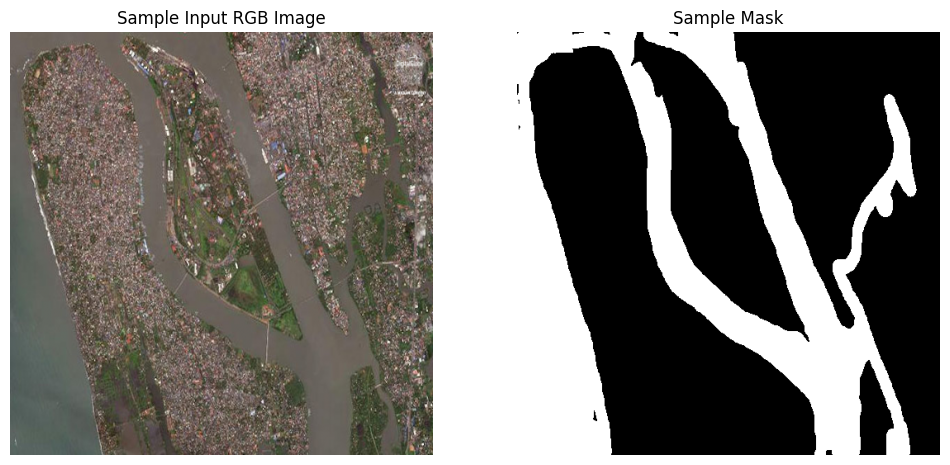

In [ ]:
# Visualize image sample and mask
index = 10 # Adjust as needed
plt.figure(figsize = (12, 6))

plt.subplot(1,2,1)
plt.imshow(train_x[index])
plt.title('Sample Input RGB Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(train_y[index].squeeze(), cmap = 'gray')
plt.title('Sample Mask')
plt.axis('off')

plt.show()

In [ ]:
# Importing TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
# Defining the Intersection Over Union (IoU) metric
def iou_metric(y_true, y_pred):
  y_pred = tf.cast(y_pred > 0.5, tf.float32)
  intersection = tf.reduce_sum(y_true * y_pred)
  union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
  return intersection / (union + 1e-7)


In [ ]:

  # Defining the UNET model
  def unet_model(input_size = (512, 512, 3)):
    x_in = Input(shape= input_size)

    # Building the Encoding Architecture
    x1 = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(x_in)
    x1 = Dropout(0.1)(x1)
    x1 = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(x1)
    p1 = MaxPooling2D((2,2))(x1)

    x2 = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(p1)
    x2 = Dropout(0.1)(x2)
    x2 = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(x2)
    p2 = MaxPooling2D((2,2))(x2)

    x3 = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(p2)
    x3 = Dropout(0.2)(x3)
    x3 = Conv2D(128, (3,3), activation = 'relu', padding = 'same')(x3)
    p3 = MaxPooling2D((2,2))(x3)

    x4 = Conv2D(256, (3,3), activation = 'relu', padding = 'same')(p3)
    x4 = Dropout(0.2)(x4)
    x4 = Conv2D(256, (3,3), activation = 'relu', padding = 'same')(x4)

    # Building the Decoder Architecture
    u1 = Conv2DTranspose(128, (3,3), strides = (2,2), padding = 'same')(x4)
    u1 = Concatenate()([u1, x3])
    u1 = Dropout(0.2)(u1)
    u1 = Conv2D(128, (3,3), activation='relu', padding = 'same')(u1)

    u2 = Conv2DTranspose(64, (3,3), strides = (2,2), padding = 'same')(u1)
    u2 = Concatenate()([u2, x2])
    u2 = Dropout(0.2)(u2)
    u2 = Conv2D(64, (3,3), activation = 'relu', padding = 'same')(u2)

    u3 = Conv2DTranspose(32, (3,3), strides = (2,2), padding = 'same')(u2)
    u3 = Concatenate()([u3, x1])
    u3 = Dropout(0.1)(u3)
    u3 = Conv2D(32, (3,3), activation = 'relu', padding = 'same')(u3)


    # Output
    outputs = Conv2D(1, (1,1), activation = 'sigmoid')(u3)

    model = Model(inputs = x_in, outputs = outputs)
    return model


In [ ]:
# Model Initialization
model = unet_model(input_size= (512, 512, 3))


In [ ]:
# Model Compilation
model.compile(optimizer= 'adam', loss = 'binary_crossentropy', metrics = ['accuracy', iou_metric])

In [ ]:
# Displaying the model's architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512, 512,  │          0 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      9,248 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256, 256,  │          0 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │     36,928 │ dropout_1[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    147,584 │ dropout_2[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    590,080 │ dropout_3[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 128, 128,  │    295,040 │ conv2d_7[0][0]  

 Total params: 1,946,881 (7.43 MB)

 Trainable params: 1,946,881 (7.43 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Setup callbacks
early_stopper = EarlyStopping(patience=10, verbose =1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor = 0.1, patience = 5, min_lr=1e-5, verbose = 1)
checkpoint = ModelCheckpoint('unet_best_model.keras', verbose = 1, save_best_only=True)

In [ ]:
# Optional Data Augumentation using ImageDagaGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation parameters
data_gen_args = dict(
    rotation_range = 10,
    width_shift_range = 0.05,
    height_shift_range = 0.05,
    shear_range = 0.05,
    zoom_range = 0.05,
    horizontal_flip =True,
    fill_mode = 'nearest'
)


In [ ]:
# Creating ImageGenerators
image_detagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)


seed = 1
batch_size = 10

image_generator = image_detagen.flow(train_x, batch_size = batch_size, seed = seed)
mask_generator = mask_datagen.flow(train_y, batch_size = batch_size, seed = seed)

# Defining the combined generator using next()
def combined_generator(image_gen, mask_gen):
  while True:
    X = next(image_gen)
    Y = next(mask_gen)
    yield X, Y

In [ ]:
# Calculating steps per epoch
steps_per_epoch = len(train_x) // batch_size

In [ ]:
# Training the model
history = model.fit(combined_generator(image_generator, mask_generator),
                    steps_per_epoch = steps_per_epoch,
                    validation_data = (test_x, test_y),# Non-augmented data for validation
                    epochs = 100,
                    callbacks = [early_stopper, reduce_lr, checkpoint]
                    )


Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 0.5666 - iou_metric: 0.1260 - loss: 0.6934
Epoch 1: val_loss improved from inf to 0.60892, saving model to unet_best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 228s 7s/step - accuracy: 0.5693 - iou_metric: 0.1296 - loss: 0.6927 - val_accuracy: 0.7264 - val_iou_metric: 0.5497 - val_loss: 0.6089 - learning_rate: 0.0010
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 937ms/step - accuracy: 0.7191 - iou_metric: 0.4798 - loss: 0.5433
Epoch 2: val_loss improved from 0.60892 to 0.50366, saving model to unet_best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.7206 - iou_metric: 0.4824 - loss: 0.5415 - val_accuracy: 0.7612 - val_iou_metric: 0.5751 - val_loss: 0.5037 - learning_rate: 0.0010
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 867ms/step - accuracy: 0.7408 - iou_metric: 0.5405 - loss: 0.5223
Epoch 3: val_loss improved from 0.50366 to 0.48749, saving model to unet_best_model.keras
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 944ms/st

In [ ]:
# Model Evaluation
test_loss, test_accuracy, test_iou = model.evaluate(test_x, test_y)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')
print(f'Test IoU: {test_iou}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 446ms/step - accuracy: 0.8655 - iou_metric: 0.7012 - loss: 0.3268
Test Loss: 0.3097522258758545
Test Accuracy: 0.8720443248748779
Test IoU: 0.7209286689758301


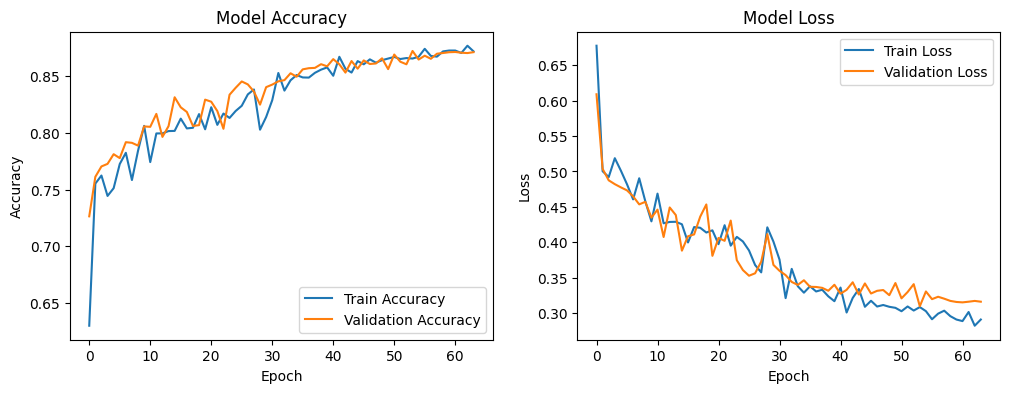

In [ ]:
# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

In [ ]:
# Saving the trained MODEL
model.save('unet_model.h5')

In [ ]:
# Prediction on test data
preds = model.predict(test_x)
preds_thresholded = (preds > 0.5).astype(np.uint8)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 461ms/step


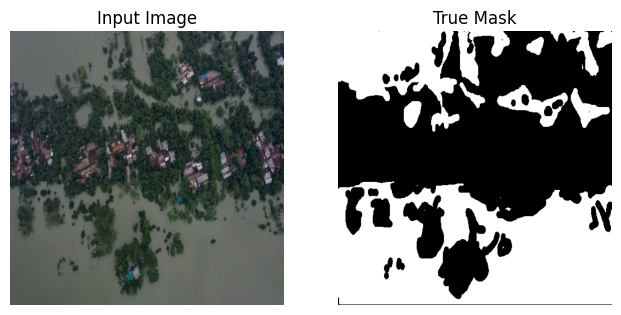

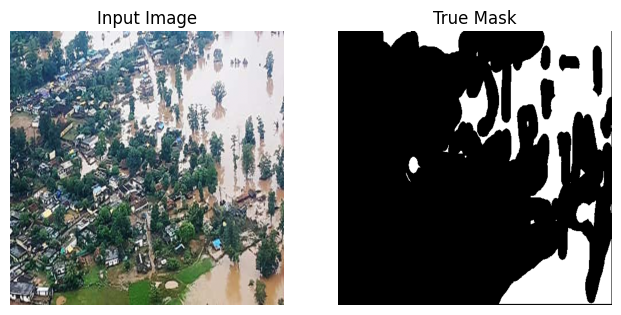

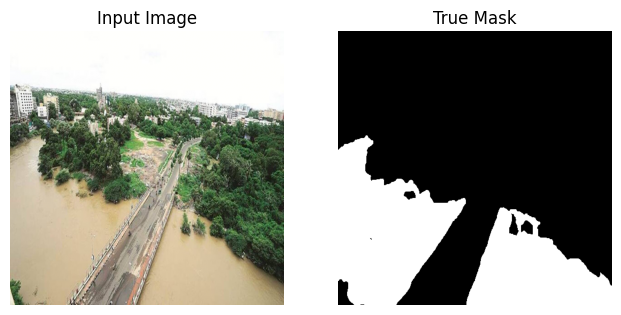

In [ ]:
# Visualizing some predictions
import random
num_examples = 3
indices = random.sample(range(len(test_x)), num_examples)

for idx in indices:
  plt.figure(figsize=(12, 4))
  plt.subplot(1,3,1)
  plt.imshow(test_x[idx])
  plt.title('Input Image')
  plt.axis('off')

  plt.subplot(1,3,2)
  plt.imshow(test_y[idx].squeeze(), cmap = 'gray')
  plt.title('True Mask')
  plt.axis('off')

  plt.show()

In [ ]:
# Printing the layer names
for layer in model.layers:
  print(layer.name)

input_layer
conv2d
dropout
conv2d_1
max_pooling2d
conv2d_2
dropout_1
conv2d_3
max_pooling2d_1
conv2d_4
dropout_2
conv2d_5
max_pooling2d_2
conv2d_6
dropout_3
conv2d_7
conv2d_transpose
concatenate
dropout_4
conv2d_8
conv2d_transpose_1
concatenate_1
dropout_5
conv2d_9
conv2d_transpose_2
concatenate_2
dropout_6
conv2d_10
conv2d_11


In [1]:
# Importing the necesssary libraries
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [2]:
# Loading the U-Net Model
model_unet = load_model('/content/drive/MyDrive/Datasets/unet_model.h5')


In [44]:
def generate_layer_gradcam(model, img_array, layer_name, target_class=0):
  # Getting the output of the target layer
  target_layer = model.get_layer(layer_name).output
  grad_cam_model = tf.keras.models.Model(inputs=model.input, outputs=[target_layer, model.output])


  with tf.GradientTape() as tape:
    # Forward pass
    last_conv_output, model_output = grad_cam_model(img_array)
    if isinstance(model_output, list):
      model_output = model_output[0]

    # Computing the loss with respect to the target class
    class_output  = tf.reduce_mean(model_output[:, :, :, target_class])
  # Compute the gradient of the class output with respect to the feature map
  grads = tape.gradient(class_output, last_conv_output)
  #Global average pooling to get importance weights
  pooled_grads = tf.reduce_mean(grads, axis = (0, 1, 2))
  # Multiply each channel in the feature map by 'How important this channel is" with respect to the target class
  last_conv_output = last_conv_output[0]
  heatmap = last_conv_output @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)
  # Normalize the heatmap
  heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-8)
  # Resizing the heatmap to match the input image size
  heatmap_resized = cv2.resize(heatmap, (img_array.shape[2], img_array.shape[1]))
  heatmap_colormap = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_HSV)
  img_array_uint8 = np.uint8(255 * img_array[0] * 255)
  gradcam_result = cv2.addWeighted(img_array_uint8, 0.6, heatmap_colormap, 0.4, 0)

  return gradcam_result, heatmap_resized

In [49]:
# Directory containing images
img_path = '/content/drive/MyDrive/Datasets/Test_Image'
image_filenames = ['1.jpg', '1008.jpg', '1019.jpg']

full_image_paths = [os.path.join(img_path, filename) for filename in image_filenames]

In [50]:
plt.figure(figsize=(12,12))
for i, file_path in enumerate(full_image_paths):
  original_img = load_img(file_path, target_size =(512, 512))
  img_array = img_to_array(original_img)
  #Normalize the image
  img_array = img_array / 255.0
  img_array = np.expand_dims(img_array, axis = 0)

  gradcam_result, heatmap_resized = generate_layer_gradcam(model_unet, img_array, "conv2d_11", 0)

  plt.subplot(len(image_filenames), 3, 3 * i + 1)
  plt.imshow(original_img)
  plt.title('Original Image - ' + image_filenames[i])
  plt.axis('off')

  plt.subplot(len(image_filenames), 3,3 * i + 2)
  plt.imshow(heatmap_resized, cmap = 'jet')
  plt.title('Grad_CAM Heatmap - ' + image_filenames[i])
  plt.axis('off')

  plt.subplot(len(image_filenames), 3, 3 * i + 3)
  plt.imshow(gradcam_result)
  plt.title('Grad-CAM Overlay - ' + image_filenames[i])
  plt.axis('off')


plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Akosombo Dam Spillage Mapping 2023

In [46]:
# Directory containing images
img_path = '/content/drive/MyDrive/Datasets/Akosombo'
image_filenames = ['Akosombo_Spillage_1.jpeg', 'Akosombo_Spillage_2.jpeg', 'Akosombo_Spillage_3.jpeg']

full_image_paths = [os.path.join(img_path, filename) for filename in image_filenames]

In [48]:
plt.figure(figsize=(12,12))
for i, file_path in enumerate(full_image_paths):
  original_img = load_img(file_path, target_size =(512, 512))
  img_array = img_to_array(original_img)
  #Normalize the image
  img_array = img_array / 255.0
  img_array = np.expand_dims(img_array, axis = 0)

  gradcam_result, heatmap_resized = generate_layer_gradcam(model_unet, img_array, "conv2d_11", 0)

  plt.subplot(len(image_filenames), 3, 3 * i + 1)
  plt.imshow(original_img)
  plt.title(image_filenames[i])
  plt.axis('off')

  plt.subplot(len(image_filenames), 3,3 * i + 2)
  plt.imshow(heatmap_resized, cmap = 'jet')
  plt.title('Grad_CAM Heatmap')
  plt.axis('off')

  plt.subplot(len(image_filenames), 3, 3 * i + 3)
  plt.imshow(gradcam_result)
  plt.title('Grad-CAM Overlay')
  plt.axis('off')


plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.